In [375]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import rtree
import re
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import math
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
%matplotlib inline

In [247]:
dockless_agg_census_chopped = pd.read_csv('../dockless_agg_census_chopped.csv',infer_datetime_format=True,\
                       parse_dates=['start_time','end_time','date'],encoding='ascii')

In [248]:
dockless_agg_census_chopped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272597 entries, 0 to 2272596
Data columns (total 8 columns):
id               object
device_id        object
trip_duration    float64
trip_distance    float64
start_time       datetime64[ns]
end_time         datetime64[ns]
date             datetime64[ns]
TRACTCE10        int64
dtypes: datetime64[ns](3), float64(2), int64(1), object(2)
memory usage: 138.7+ MB


In [249]:
dockless_agg_census_chopped.describe()

,trip_duration,trip_distance,TRACTCE10
count,2.272597e+06,2.272597e+06,2.272597e+06
mean,6.881278e+02,1.503344e+03,9.905842e+02
std,8.558635e+02,1.626510e+03,2.384573e+03
min,1.100000e+01,1.100000e+01,1.010000e+02
25%,2.460000e+02,5.380000e+02,6.030000e+02
50%,4.120000e+02,1.018000e+03,1.100000e+03
75%,7.960000e+02,1.866000e+03,1.100000e+03
max,3.969000e+04,3.980000e+04,9.800000e+05


In [250]:
groupby_ct = dockless_agg_census_chopped.groupby('TRACTCE10',as_index=False).count()[['TRACTCE10','id']].sort_values('id')

### Baseline model which detects events based on time series forecasting of the number of trips per day

In [251]:
groupby_date = dockless_agg_census_chopped.groupby('date').count()[['id']].sort_index()

In [252]:
groupby_date = groupby_date[27:]

In [253]:
groupby_date.shape

(266, 1)

In [254]:
groupby_date.rename({'id':'no_of_trips'},axis=1,inplace=True)

In [255]:
train, test = groupby_date[0:-90], groupby_date[-90:]
train_log, test_log = np.log10(train), np.log10(test)
my_order = (1, 1, 1)
my_seasonal_order = (0, 1, 1, 7)

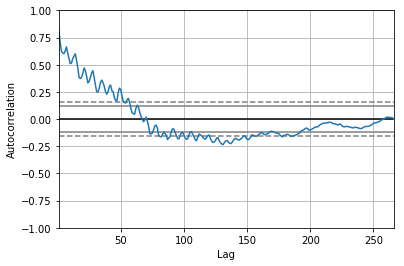

In [256]:
autocorrelation_plot(groupby_date)

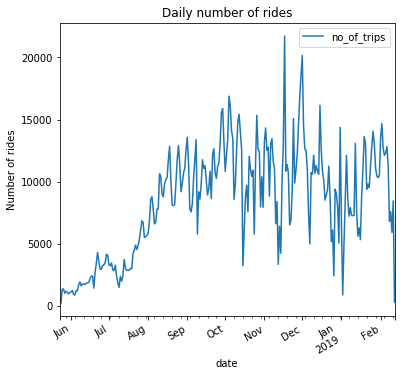

In [257]:
fig,ax = plt.subplots()
groupby_date.plot.line(y='no_of_trips',figsize=(6,6),ax=ax)
plt.ylabel('Number of rides')
plt.title('Daily number of rides')
ax.xaxis_date()     
fig.autofmt_xdate()

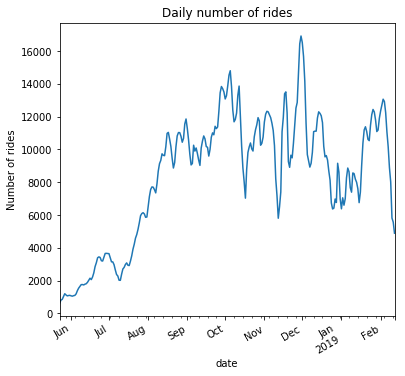

In [258]:
fig,ax = plt.subplots()
groupby_date.no_of_trips.rolling(5,center=True,min_periods=1,axis=0).mean().plot.line(y='no_of_trips',figsize=(6,6),ax=ax)
plt.ylabel('Number of rides')
plt.title('Daily number of rides')
ax.xaxis_date()     
fig.autofmt_xdate()

In [284]:
%%time
history = [x for x in train_log.values]
predictions = []
predict_log= []
for key,value in test_log.iterrows():
    model = sm.tsa.SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
    model_fit = model.fit(disp=0,maxiter=200,method='powell')
    output = model_fit.forecast()
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = test_log.loc[key]
    history.append(obs)

CPU times: user 1min 25s, sys: 354 ms, total: 1min 26s
Wall time: 35.7 s


In [285]:
predicted_df=pd.DataFrame()
predicted_df['date']=groupby_date.index[-90:]
predicted_df['actuals']= test.values
predicted_df['predicted']=predictions
predicted_df.reset_index(inplace=True)
del predicted_df['index']
predicted_df.head()

,date,actuals,predicted
0,2018-11-15,10117,5980.296974
1,2018-11-16,12917,8989.242280
2,2018-11-17,21727,9505.130453
3,2018-11-18,10843,14871.235448
4,2018-11-19,11378,6772.447597


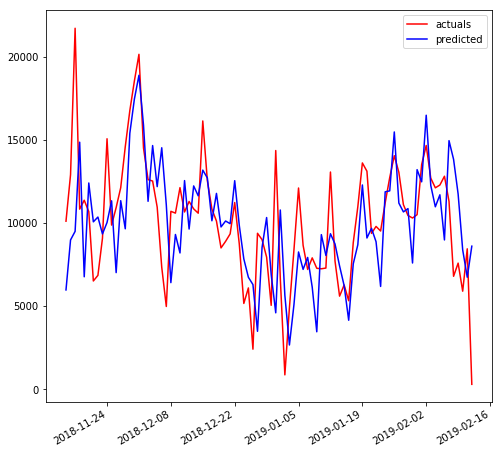

In [286]:
fig,ax = plt.subplots(figsize=(8, 8))
ax.plot(predicted_df.date,predicted_df.actuals,'r')
ax.plot(predicted_df.date,predicted_df.predicted,'b')
ax.xaxis_date()     
fig.autofmt_xdate()
plt.legend()

In [287]:
import numpy as np
def detect_classify_anomalies(df,window):
    df.replace([np.inf, -np.inf], np.NaN, inplace=True)
    df.fillna(0,inplace=True)
    df['error']=df['actuals']-df['predicted']
    df['percentage_change'] = (df['error'] / df['actuals']) * 100
    df['meanval'] = df['error'].mean()#rolling(window=window,center=True,min_periods=1).mean()
    df['deviation'] = df['error'].std()#rolling(window=window,center=True,min_periods=1).std()
    df['anomaly'] = df.apply(lambda x: 1 if(x['error']>=x['meanval']+2*x['deviation']\
                                            or x['error']<=x['meanval']-2*x['deviation'] ) else 0,axis=1)
    df = df.sort_values(by='date')
    df.date = pd.to_datetime(df['date'].astype(str), format="%Y-%m-%d")
    return df

In [288]:
classify_df=detect_classify_anomalies(predicted_df,5)
classify_df.reset_index(inplace=True,drop=True)

In [289]:
classify_df[classify_df['anomaly']==1]

,date,actuals,predicted,error,percentage_change,meanval,deviation,anomaly
2,2018-11-17,21727,9505.130453,12221.869547,56.251989,229.24923,3339.326446,1
21,2018-12-06,7343,14536.223550,-7193.223550,-97.960283,229.24923,3339.326446,1
46,2018-12-31,14369,4603.836887,9765.163113,67.959935,229.24923,3339.326446,1
85,2019-02-08,6802,13841.631193,-7039.631193,-103.493549,229.24923,3339.326446,1
89,2019-02-12,300,8614.402073,-8314.402073,-2771.467358,229.24923,3339.326446,1


In [290]:
classify_df.loc[classify_df['anomaly']==1].actuals

2     21727
21     7343
46    14369
85     6802
89      300
Name: actuals, dtype: int64

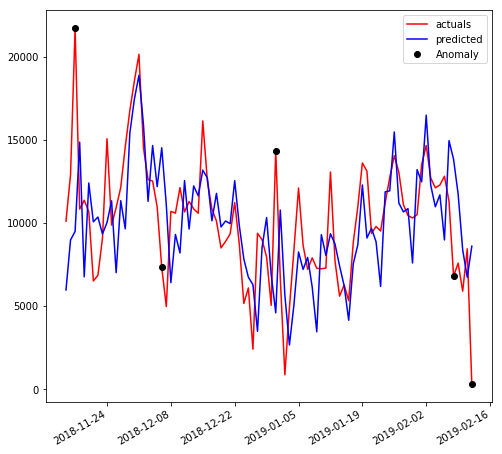

In [292]:
fig,ax = plt.subplots(figsize=(8, 8))
ax.plot(classify_df.date,classify_df.actuals,'r')
ax.plot(classify_df.date,classify_df.predicted,'b')
ax.plot(classify_df.loc[classify_df['anomaly']==1].date,classify_df.loc[classify_df['anomaly']==1].actuals,\
        'o',color='black',label='Anomaly')
ax.xaxis_date()     
fig.autofmt_xdate()
plt.legend()

### Isolation Forest using number of trips, average distance and duration of trips

In [29]:
dockless_agg_census_chopped.pivot_table(index='date',columns='TRACTCE10',values='id',aggfunc='count',fill_value=0)[50:56]

TRACTCE10,101,102,203,204,205,206,302,304,305,306,307,401,402,500,601,603,604,700,801,802,803,804,901,902,1000,...,2427,2428,2429,2430,2431,2432,2433,2435,2500,10901,20311,20316,20318,20403,20404,20405,20406,20408,20409,20410,20411,20508,20509,20510,980000
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-15,0,0,0,1,0,0,0,0,0,0,0,19,1,4,58,36,37,92,0,0,1,7,26,112,21,...,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-06-16,0,0,0,0,0,0,0,0,1,1,0,6,3,0,28,31,35,91,0,1,1,10,21,181,61,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-06-17,1,0,0,1,1,0,0,0,0,0,1,7,5,3,33,12,9,106,0,0,3,10,34,185,36,...,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-06-18,0,0,0,2,0,0,2,0,0,2,0,25,3,5,142,67,64,74,1,0,0,4,23,101,15,...,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-06-19,0,0,0,0,0,0,1,0,0,0,0,6,0,2,165,74,42,28,0,0,2,6,2,82,19,...,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-06-20,0,0,0,3,0,0,2,0,0,2,0,33,3,13,293,129,113,87,0,1,0,9,23,106,8,...,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [293]:
dockless_agg_census_chopped.head()

,id,device_id,trip_duration,trip_distance,start_time,end_time,date,TRACTCE10
0,000000cb-78a9-4b95-8ead-37c797abcf37,ad14e63b-940d-4ca3-84c6-0131147fba45,358.0,915.0,2018-06-29 17:30:00,2018-06-29 17:30:00,2018-06-29,1303
1,00001b5f-46aa-4b26-a12f-d7b4d3c69834,c5a230c9-7e80-4464-862f-f2b23f61d6d3,226.0,839.0,2018-11-30 11:00:00,2018-11-30 11:00:00,2018-11-30,604
2,00002334-2f2b-41a0-9a04-8ff66be39f40,5a9f7815-bf0c-4fef-8bac-60efd4f23b10,324.0,1206.0,2018-10-02 15:15:00,2018-10-02 15:30:00,2018-10-02,601
3,00002c70-678b-4c09-a32c-da0266e329c6,ddd4bbc3-114e-4cbc-b078-860e3c28b11b,408.0,1144.0,2018-09-28 11:45:00,2018-09-28 11:45:00,2018-09-28,2304
4,00002f2a-0bcd-4446-bb39-df9fd62be813,d7f470bf-8f4f-4a07-bed7-1f091014920f,1094.0,2631.0,2018-07-22 16:30:00,2018-07-22 16:45:00,2018-07-22,1305


In [583]:
trip_info = dockless_agg_census_chopped.groupby('date',as_index=False).mean()[['date','trip_duration','trip_distance']]

In [584]:
trip_count = dockless_agg_census_chopped.groupby('date',as_index=False).count()[['date','id']]
trip_count.rename({'id':'no_of_trips'},axis=1,inplace=True)

In [585]:
trip_info = trip_info.merge(trip_count,on='date')

In [586]:
trip_info = trip_info.iloc[27:].reset_index(drop=True)

In [587]:
trip_info_orig = trip_info.copy()

#### The contamination(% of total which are outliers) parameter of the Isolation Forest needs to be played around with in order to see if the predicted anomalies make sense. So, we apply PCA on the 3 standardized features and then, we make a scatter plot of the 2 most prominent features. There is a obvious trade-off here between the number of False Positives and False Negatives. In our case, it would be better to identify some normal days as anomalous rather than missing anomalous days and classifying them as normal.

#### Contamination = 0.08

In [588]:
# Standardize the features
data = pd.DataFrame(StandardScaler().fit_transform(trip_info.iloc[:,1:4]))
# Train the model(contamination needs to be played with to get the ideal value)
model =  IsolationForest(contamination=0.08,behaviour='new',random_state=2019)
model.fit(data) 
trip_info['anomaly'] = pd.Series(model.predict(data))
# -1 prediction means it is an outlier.
outlier_index = list(trip_info[trip_info['anomaly']==-1].index)
print(trip_info.anomaly.value_counts())

/anaconda3/envs/nishi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/nishi/lib/python2.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


 1    244
-1     22
Name: anomaly, dtype: int64


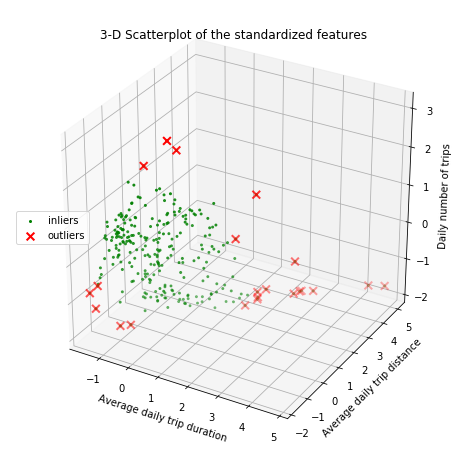

In [589]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3-D Scatterplot of the standardized features')
ax.set_xlabel("Average daily trip duration")
ax.set_ylabel("Average daily trip distance")
ax.set_zlabel("Daily number of trips")
# Plot the compressed data points
ax.scatter(data.iloc[:, 0], data.iloc[:, 1], zs=data.iloc[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(data.iloc[outlier_index,0],data.iloc[outlier_index,1], data.iloc[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend(loc='center left')
plt.show()

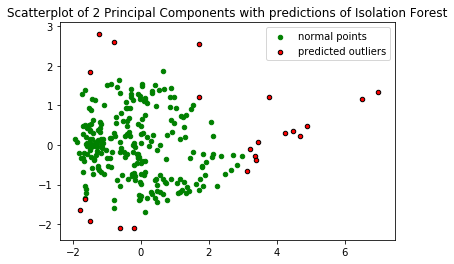

In [590]:
pca = PCA(2)
pca.fit(data)
res=pd.DataFrame(pca.transform(data))
Z = np.array(res)
plt.title("Scatterplot of 2 Principal Components with predictions of Isolation Forest")
# plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res.iloc[~res.index.isin(outlier_index),0], res.iloc[~res.index.isin(outlier_index),1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='red',s=20,  edgecolor="black",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

#### Contamination = 0.12

In [591]:
# Standardize the features
data = pd.DataFrame(StandardScaler().fit_transform(trip_info.iloc[:,1:4]))
# Train the model(contamination needs to be played with to get the ideal value)
model =  IsolationForest(contamination=0.12,behaviour='new',random_state=2019)
model.fit(data) 
trip_info['anomaly'] = pd.Series(model.predict(data))
outlier_index = list(trip_info[trip_info['anomaly']==-1].index)
print(trip_info.anomaly.value_counts())

/anaconda3/envs/nishi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/nishi/lib/python2.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


 1    234
-1     32
Name: anomaly, dtype: int64


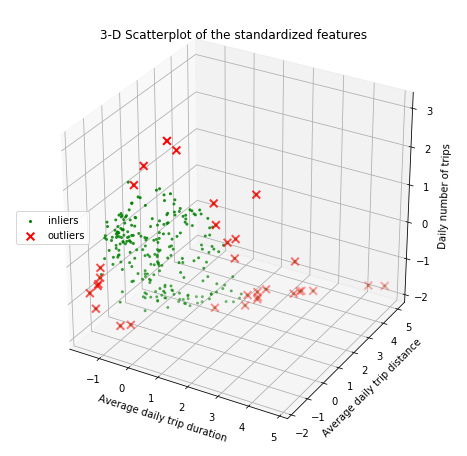

In [592]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3-D Scatterplot of the standardized features')
ax.set_xlabel("Average daily trip duration")
ax.set_ylabel("Average daily trip distance")
ax.set_zlabel("Daily number of trips")
# Plot the compressed data points
ax.scatter(data.iloc[:, 0], data.iloc[:, 1], zs=data.iloc[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(data.iloc[outlier_index,0],data.iloc[outlier_index,1], data.iloc[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend(loc='center left')
plt.show()

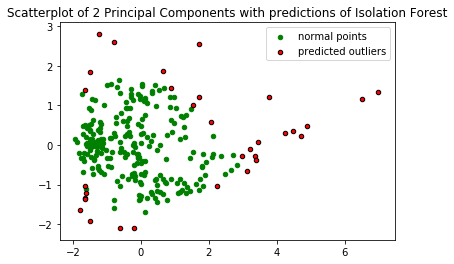

In [593]:
pca = PCA(2)
pca.fit(data)
res=pd.DataFrame(pca.transform(data))
Z = np.array(res)
plt.title("Scatterplot of 2 Principal Components with predictions of Isolation Forest")
# plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res.iloc[~res.index.isin(outlier_index),0], res.iloc[~res.index.isin(outlier_index),1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='red',s=20,  edgecolor="black",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

#### Contamination = 0.14

In [594]:
# Standardize the features
data = pd.DataFrame(StandardScaler().fit_transform(trip_info.iloc[:,1:4]))
# Train the model(contamination needs to be played with to get the ideal value)
model =  IsolationForest(contamination=0.14,behaviour='new',random_state=2019)
model.fit(data) 
trip_info['anomaly'] = pd.Series(model.predict(data))
outlier_index = list(trip_info[trip_info['anomaly']==-1].index)
print(trip_info.anomaly.value_counts())

/anaconda3/envs/nishi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/nishi/lib/python2.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


 1    228
-1     38
Name: anomaly, dtype: int64


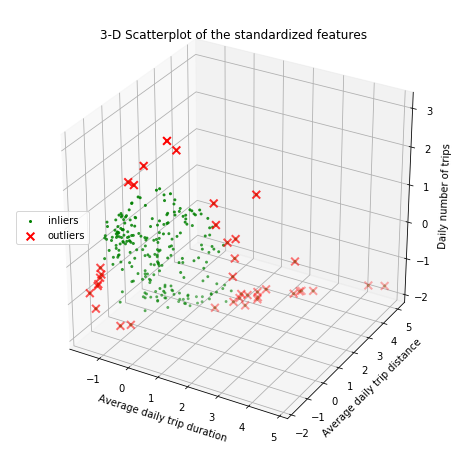

In [595]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3-D Scatterplot of the standardized features')
ax.set_xlabel("Average daily trip duration")
ax.set_ylabel("Average daily trip distance")
ax.set_zlabel("Daily number of trips")
# Plot the compressed data points
ax.scatter(data.iloc[:, 0], data.iloc[:, 1], zs=data.iloc[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(data.iloc[outlier_index,0],data.iloc[outlier_index,1], data.iloc[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend(loc='center left')
plt.show()

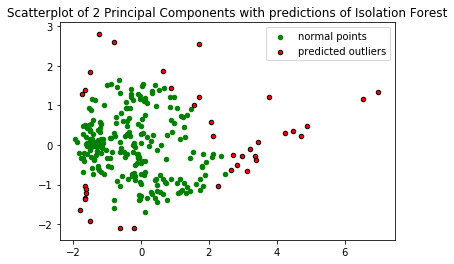

In [596]:
pca = PCA(2)
pca.fit(data)
res=pd.DataFrame(pca.transform(data))
Z = np.array(res)
plt.title("Scatterplot of 2 Principal Components with predictions of Isolation Forest")
# plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res.iloc[~res.index.isin(outlier_index),0], res.iloc[~res.index.isin(outlier_index),1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='red',s=20,  edgecolor="black",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

#### As we can see from the above plots, 0.14 seems to be a good value for contamination as 0.08 and 0.12 miss a few anomalies and our target is to be able to detect more anomalies even at the cost of increasing the number of False positives(Uptil a certain extent).

In [597]:
# Standardize the features
data = pd.DataFrame(StandardScaler().fit_transform(trip_info.iloc[:,1:4]))
# Train the model(contamination needs to be played with to get the ideal value)
model =  IsolationForest(contamination=0.14,behaviour='new',random_state=2019)
model.fit(data) 
trip_info['anomaly'] = pd.Series(model.predict(data))
outlier_index = list(trip_info[trip_info['anomaly']==-1].index)
print(trip_info.anomaly.value_counts())

/anaconda3/envs/nishi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/nishi/lib/python2.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


 1    228
-1     38
Name: anomaly, dtype: int64


In [598]:
trip_info[trip_info['anomaly']==-1]

,date,trip_duration,trip_distance,no_of_trips,anomaly
0,2018-05-23,897.798742,2172.723270,318,-1
1,2018-05-24,1041.973214,2428.272321,224,-1
2,2018-05-25,1022.062921,2356.399251,1335,-1
3,2018-05-26,1377.925899,2969.234043,1363,-1
4,2018-05-27,1720.495540,3596.255699,1009,-1
5,2018-05-28,1636.696763,3472.895230,1174,-1
9,2018-06-01,1001.497312,2275.826165,1116,-1
10,2018-06-02,1110.714286,2507.405844,1232,-1
11,2018-06-03,1294.433581,2973.352816,941,-1
12,2018-06-04,1101.848131,2524.939252,856,-1


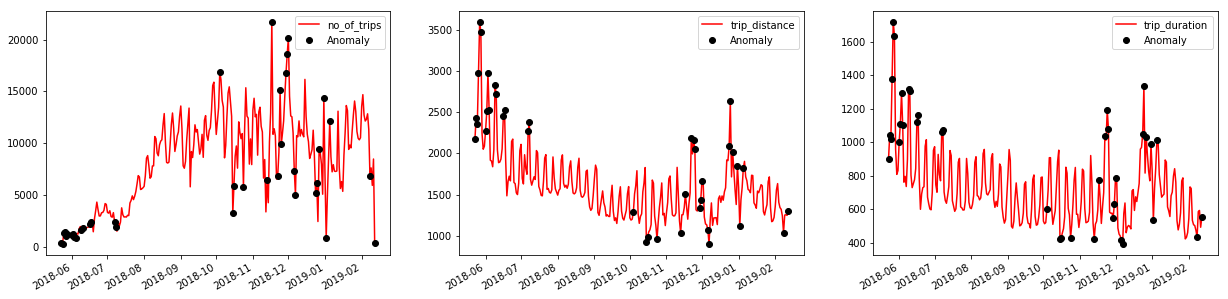

In [599]:
fig,ax = plt.subplots(1,3,figsize=(21, 5))
ax[0].plot(trip_info.date,trip_info.no_of_trips,'r')
ax[0].plot(trip_info.loc[trip_info['anomaly']==-1].date,trip_info.loc[trip_info['anomaly']==-1].no_of_trips,\
        'o',color='black',label='Anomaly')
ax[0].xaxis_date()     
fig.autofmt_xdate()
ax[0].legend()

ax[1].plot(trip_info.date,trip_info.trip_distance,'r')
ax[1].plot(trip_info.loc[trip_info['anomaly']==-1].date,trip_info.loc[trip_info['anomaly']==-1].trip_distance,\
        'o',color='black',label='Anomaly')
ax[1].xaxis_date()     
fig.autofmt_xdate()
ax[1].legend()

ax[2].plot(trip_info.date,trip_info.trip_duration,'r')
ax[2].plot(trip_info.loc[trip_info['anomaly']==-1].date,trip_info.loc[trip_info['anomaly']==-1].trip_duration,\
        'o',color='black',label='Anomaly')
ax[2].xaxis_date()     
fig.autofmt_xdate()
ax[2].legend()

### Local Outlier Factor

In [600]:
dockless_agg_census_chopped.head()

,id,device_id,trip_duration,trip_distance,start_time,end_time,date,TRACTCE10
0,000000cb-78a9-4b95-8ead-37c797abcf37,ad14e63b-940d-4ca3-84c6-0131147fba45,358.0,915.0,2018-06-29 17:30:00,2018-06-29 17:30:00,2018-06-29,1303
1,00001b5f-46aa-4b26-a12f-d7b4d3c69834,c5a230c9-7e80-4464-862f-f2b23f61d6d3,226.0,839.0,2018-11-30 11:00:00,2018-11-30 11:00:00,2018-11-30,604
2,00002334-2f2b-41a0-9a04-8ff66be39f40,5a9f7815-bf0c-4fef-8bac-60efd4f23b10,324.0,1206.0,2018-10-02 15:15:00,2018-10-02 15:30:00,2018-10-02,601
3,00002c70-678b-4c09-a32c-da0266e329c6,ddd4bbc3-114e-4cbc-b078-860e3c28b11b,408.0,1144.0,2018-09-28 11:45:00,2018-09-28 11:45:00,2018-09-28,2304
4,00002f2a-0bcd-4446-bb39-df9fd62be813,d7f470bf-8f4f-4a07-bed7-1f091014920f,1094.0,2631.0,2018-07-22 16:30:00,2018-07-22 16:45:00,2018-07-22,1305


In [609]:
X = StandardScaler().fit_transform(trip_info_orig.iloc[:,1:4])

/anaconda3/envs/nishi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/nishi/lib/python2.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


#### Just like Isolation Forest, we apply PCA on the 3 standardized features and then, we make a plot of the 2 most prominent features to decide an ideal contamination value.

In [791]:
clf = LocalOutlierFactor(contamination=0.10)
anomaly = clf.fit_predict(X)
nof = clf.negative_outlier_factor_ #NOF

In [792]:
pca = PCA(2)
pca.fit(X)
res=pd.DataFrame(pca.transform(X))

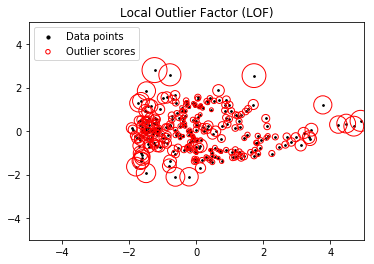

In [793]:
plt.title("Local Outlier Factor (LOF)")
plt.scatter(res[0], res[1], color='k', s=3., label='Data points')
# The radius depends on the NOF score
radius = (nof.max() - nof) / (nof.max() - nof.min())
plt.scatter(res[0], res[1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [794]:
clf = LocalOutlierFactor(n_neighbors=20,contamination=0.08)
anomaly = clf.fit_predict(X)
nof = clf.negative_outlier_factor_ #NOF

In [795]:
pca = PCA(2)
pca.fit(X)
res=pd.DataFrame(pca.transform(X))

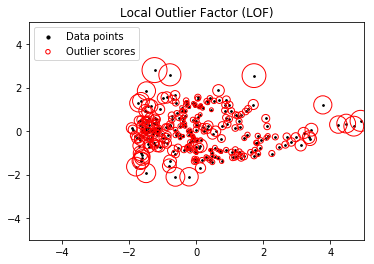

In [796]:
plt.title("Local Outlier Factor (LOF)")
plt.scatter(res[0], res[1], color='k', s=3., label='Data points')
# The radius depends on the NOF score
radius = (nof.max() - nof) / (nof.max() - nof.min())
plt.scatter(res[0], res[1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [797]:
# In negative_outlier_factor_, Inliers tend to have a negative_outlier_factor_ close to -1
# while outliers tend to have a larger LOF score(negative)
trip_info_orig['anomaly'] = anomaly

In [798]:
trip_info_orig.head()

,date,trip_duration,trip_distance,no_of_trips,anomaly
0,2018-05-23,897.798742,2172.723270,318,1
1,2018-05-24,1041.973214,2428.272321,224,1
2,2018-05-25,1022.062921,2356.399251,1335,1
3,2018-05-26,1377.925899,2969.234043,1363,-1
4,2018-05-27,1720.495540,3596.255699,1009,-1


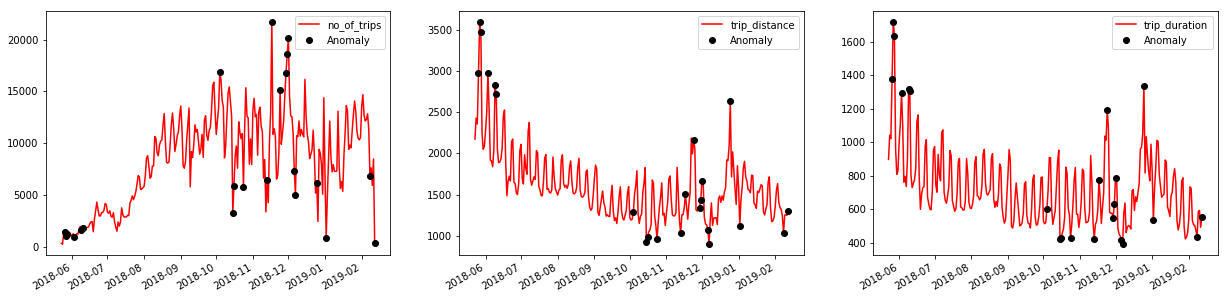

In [799]:
fig,ax = plt.subplots(1,3,figsize=(21, 5))
ax[0].plot(trip_info_orig.date,trip_info_orig.no_of_trips,'r')
ax[0].plot(trip_info_orig.loc[trip_info_orig['anomaly']==-1].date,\
           trip_info_orig.loc[trip_info_orig['anomaly']==-1].no_of_trips,\
        'o',color='black',label='Anomaly')
ax[0].xaxis_date()     
fig.autofmt_xdate()
ax[0].legend()

ax[1].plot(trip_info_orig.date,trip_info_orig.trip_distance,'r')
ax[1].plot(trip_info_orig.loc[trip_info_orig['anomaly']==-1].date,\
           trip_info_orig.loc[trip_info_orig['anomaly']==-1].trip_distance,\
        'o',color='black',label='Anomaly')
ax[1].xaxis_date()     
fig.autofmt_xdate()
ax[1].legend()

ax[2].plot(trip_info_orig.date,trip_info_orig.trip_duration,'r')
ax[2].plot(trip_info_orig.loc[trip_info_orig['anomaly']==-1].date,\
           trip_info_orig.loc[trip_info_orig['anomaly']==-1].trip_duration,\
        'o',color='black',label='Anomaly')
ax[2].xaxis_date()     
fig.autofmt_xdate()
ax[2].legend()

In [800]:
trip_info_orig[200:230]

,date,trip_duration,trip_distance,no_of_trips,anomaly
200,2018-12-09,637.616712,1398.548524,10603,1
201,2018-12-10,460.057432,1127.006180,12136,1
202,2018-12-11,492.734258,1216.958677,10672,1
203,2018-12-12,503.281670,1217.485934,11304,1
204,2018-12-13,497.793977,1220.520262,10858,1
205,2018-12-14,482.837721,1136.141334,10599,1
206,2018-12-15,710.364914,1451.087745,16149,1
207,2018-12-16,717.459524,1483.410332,12563,1
208,2018-12-17,592.895315,1405.328814,10842,1
209,2018-12-18,674.411160,1483.225679,10125,1
